<a href="https://colab.research.google.com/github/JoonhyeonKim/Fun_with_practicing_DS/blob/main/04_pytorch_custom_datasets_exercises_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

Sun Mar 10 03:11:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.1.0+cu121


'cuda'

# 1. Get data

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.


# 2. Become one with the data (data preparation)

In [4]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
      dir_path (str or pathlib.Path): target directory

  Returns:
      A print out of:
          number of subdirectories in dir_path
          number of images (files) in each subdirectory
          name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")


In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'


In [6]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"


In [7]:
train_dir, test_dir


(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## Visualize an image

1. Get all of the image paths using pathlib.Path.glob() to find all of the files ending in .jpg.
2. Pick a random image path using Python's random.choice().
3. Get the image class name using pathlib.Path.parent.stem.
4. And since we're working with images, we'll open the random image path using PIL.Image.open() (PIL stands for Python Image Library).
5. We'll then show the image and print some metadata.

In [8]:
import random
from PIL import Image

In [9]:
# Set seed
random.seed(42)

In [10]:
# 1. Get all image paths(* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

In [11]:
# 2. Get random image path
random_image_path = random.choice(image_path_list)

In [12]:
# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

In [13]:
# 4. Open image
img = Image.open(random_image_path)

Random image path: data/pizza_steak_sushi/train/pizza/2811032.jpg
Image class: pizza
Image height: 512
Image width: 512


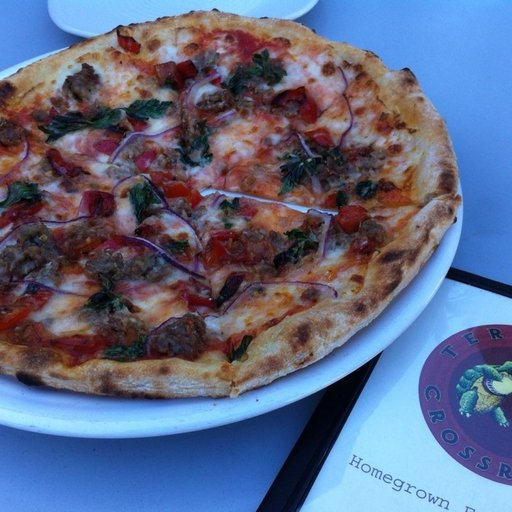

In [14]:
# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 511.5, -0.5)

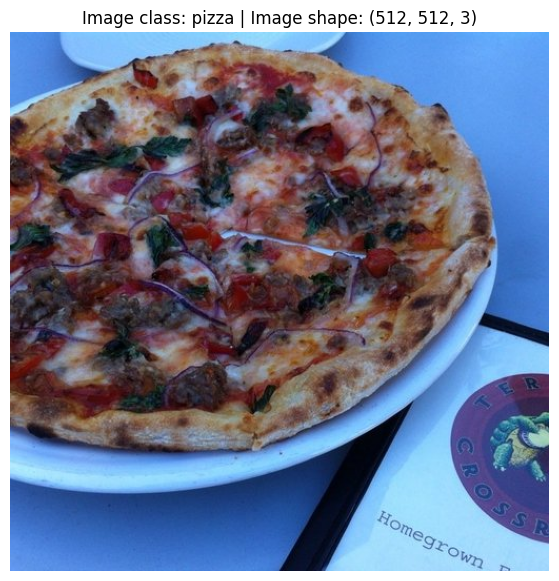

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape}")

plt.axis(False)

# Transforming data

In [16]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


## Transforming data with torchvision.transforms

In [17]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the image to 64X64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

In [18]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

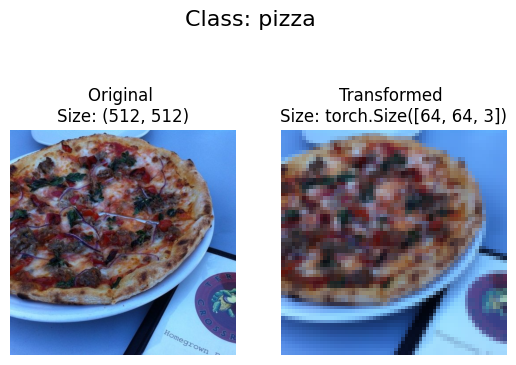

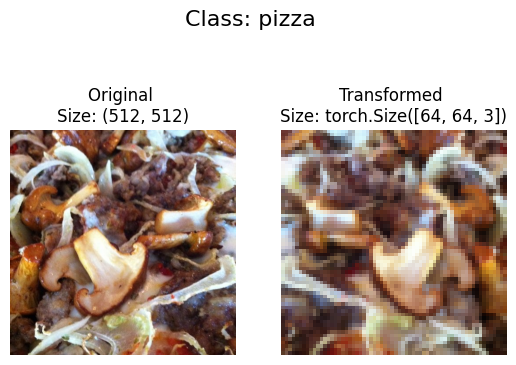

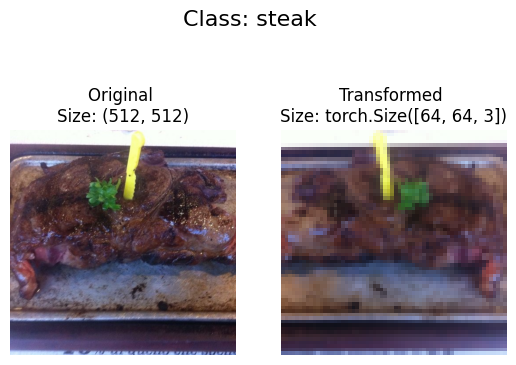

In [19]:
plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)


# Option 1: Loading Image Data Using ImageFolder

In [20]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)


In [21]:
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

In [22]:
# Get class names as a list

class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [23]:
# Can also get class names as a dict

class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [24]:
# Check the lengths
len(train_data), len(test_data)

(225, 75)

In [25]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

In [26]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0) # so first dim goes to last

In [27]:
# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color]")


Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color]


Text(0.5, 1.0, 'pizza')

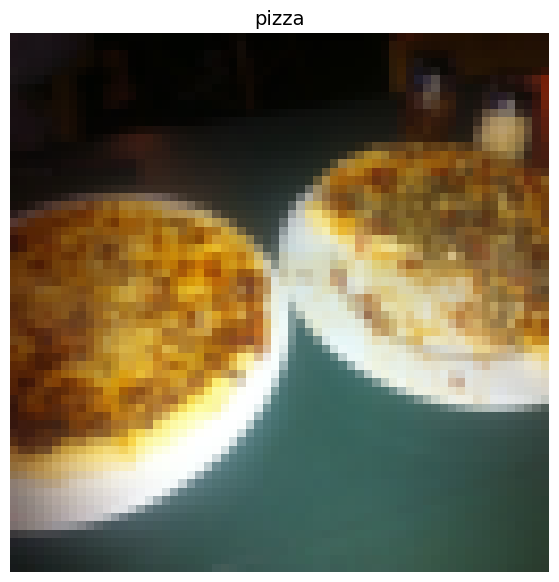

In [28]:
# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img.permute(1,2,0))
plt.axis("off")

plt.title(class_names[label], fontsize=14)

## Turn loaded images into DataLoader's

In [29]:
os.cpu_count()


2

In [30]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader

In [31]:
train_dataloader = DataLoader(dataset=train_data,
           batch_size=1, # how many samples per batch?
           num_workers=1, # how many subprocesses to use for data loading? (higher = more)
           shuffle=True) # shuffle the data?

In [32]:
test_dataloader = DataLoader(dataset=test_data,
           batch_size=1, # how many samples per batch?
           num_workers=1, # how many subprocesses to use for data loading? (higher = more)
           shuffle=False) # shuffle the data?

In [33]:
train_dataloader, test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x7ddad4ac3610>,
 <torch.utils.data.dataloader.DataLoader at 0x7ddad4ac2980>)

In [34]:
img, label = next(iter(train_dataloader))


In [35]:
# Batch size will now be 1, try chaining the batch_size parameter above and see what happens

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


# Option 2: Loading Image Data with a Custom Dataset

In [36]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [37]:
# Instance of torchvision.datasets.Image
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

## Creating a helper function to get class names

In [38]:
# Setup path for target dicrectory
target_directory = train_dir
print(f"Target directory: {target_directory}")


Target directory: data/pizza_steak_sushi/train


In [39]:
# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])

print(f"Class names found: {class_names_found}")

Class names found: ['pizza', 'steak', 'sushi']


In [40]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.

    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))

    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names not found
    if not classes:
      raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [41]:
print(train_dir)
find_classes(train_dir)

data/pizza_steak_sushi/train


(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

## Create a custom Dataset to replicate ImageFolder

In [42]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

  # 2. Initialize with a tar_dir and transform (optional) parameter
  def __init__(self, targ_dir: str, transform=None) -> None:

    # 3. Create class asttributes
    # Get all image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got '.png' or '.jpeg's
    # Setup transforms
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Make function to load images
  def load_image(self, index: int) -> Image.Image:
    "Opens an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)

  # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X,y)
    else:
      return img, class_idx # return data, label (X, y)



In [43]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [44]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7ddad4ad16c0>,
 <__main__.ImageFolderCustom at 0x7ddad4ad3040>)

In [45]:
len(train_data_custom), len(test_data_custom)


(225, 75)

In [46]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [47]:
test_data_custom.classes

['pizza', 'steak', 'sushi']

In [48]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


## Create a function to display random images

In [49]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

  # 2. Adjust display if n too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display")

  # 3. Set rando0m seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_sample_idx = random.sample(range(len(dataset)), k=n)

  # 5. Setup plot
  plt.figure(figsize=(16, 8))

  # 6. Loop through samples and display random samples
  for i, targ_sample in enumerate(random_sample_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [height, width, color_channels]
    targ_image_adjust = targ_image.permute(1,2,0)

    # Plot adjusted samples
    plt.subplot(1, n, i+1) # n for the number of images displayed
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

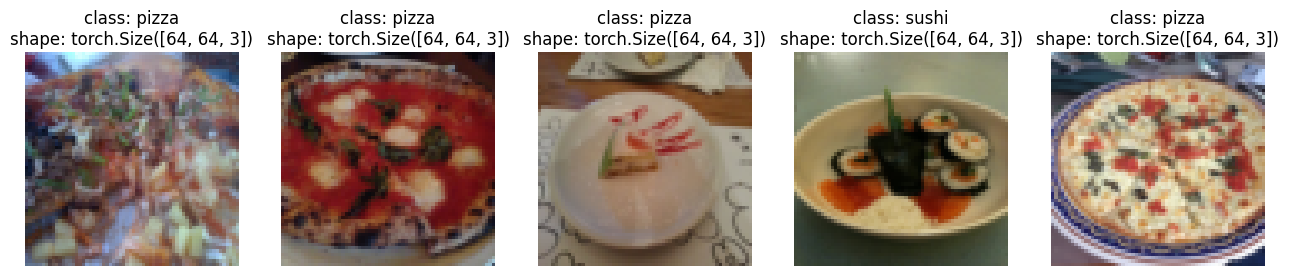

In [50]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)


For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display


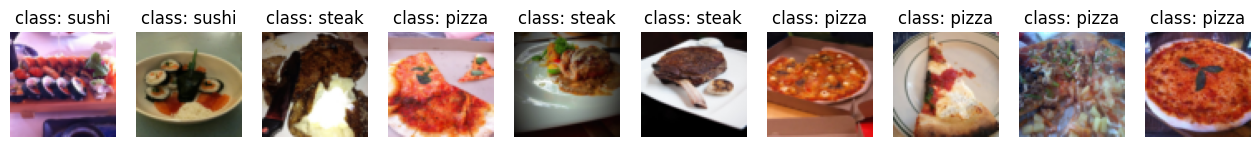

In [51]:
# Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=12,
                      classes=class_names,
                      seed=None) # Try setting the seed for reproducible


## Turn custom loaded images into DataLoader's

In [52]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=8, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=8,
                                    num_workers=0,
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7ddad4b0f040>,
 <torch.utils.data.dataloader.DataLoader at 0x7ddad4b0e020>)

In [53]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([8, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([8])


# Other forms of transforms (data augmentation)

Machine learning is all about harnessing the power of randomness and research shows that random transforms (like transforms.RandAugment() and transforms.TrivialAugmentWide()) generally perform better than hand-picked transforms.



In [54]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])
# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

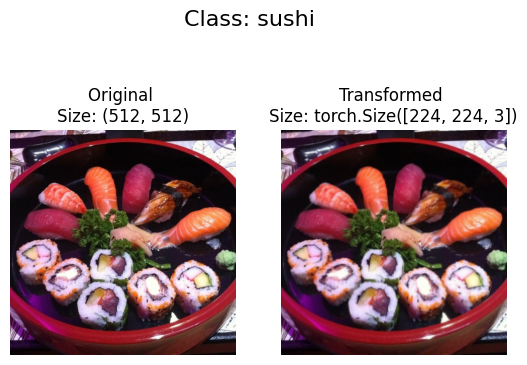

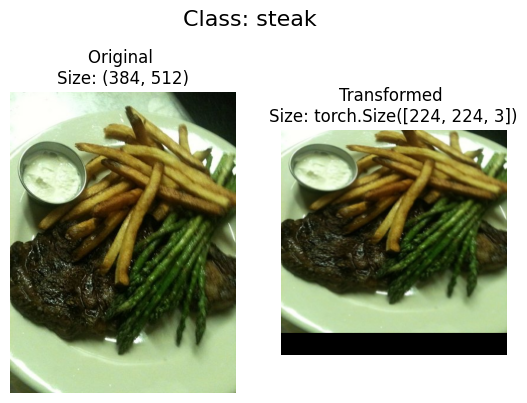

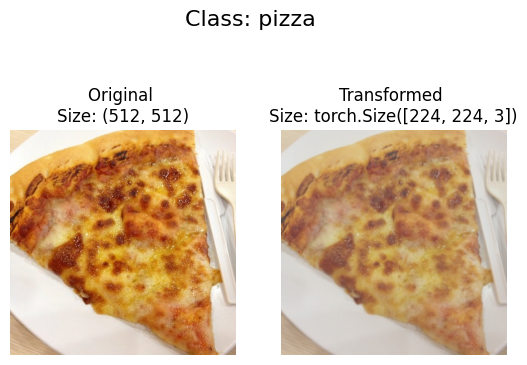

In [55]:
# Get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

# Model 0: TinyVGG without data augmentation

## Creating transforms and loading data for Model 0

In [56]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])


In [57]:
# 1. Load and transform data
from torchvision import datasets

In [58]:
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

In [59]:
# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader


In [60]:
# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

Creating DataLoader's with batch size 32 and 2 workers.


In [61]:
# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)
train_dataloader_simple, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7ddad4828ca0>,
 <torch.utils.data.dataloader.DataLoader at 0x7ddad4828fd0>)

## Create TinyVGG model class

In [62]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from:
  https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3, # how big is the square that's going over the image?
                  stride=1, # default
                  padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
        )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        # Where did this in_features shape come from?
        # It's because each layer of our network compresses and changes the shape of our inputs data.
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x
    # return self.classifier(self.conv_block_2(self.conv_block_1(x)))


In [63]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

In [64]:
model_0


TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

Note: One of the ways to speed up deep learning models computing on a GPU is to leverage operator fusion.

This means in the forward() method in our model above, instead of calling a layer block and reassigning x every time, we call each block in succession (see the final line of the forward() method in the model above for an example).

## Try a forward pass on a single image (to test the model)

To do a forward pass on a single image, let's:

1. Get a batch of images and labels from the DataLoader.
2. Get a single image from the batch and unsqueeze() the image so it has a batch size of 1 (so its shape fits the model).
3. Perform inference on a single image (making sure to send the image to the target device).
4. Print out what's happening and convert the model's raw output logits to prediction probabilities with torch.softmax() (since we're working with multi-class data) and convert the prediction probabilities to prediction labels with torch.argmax().

In [65]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
  pred = model_0(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0578, 0.0634, 0.0351]], device='cuda:0')

Output prediction probabilities:
tensor([[0.3352, 0.3371, 0.3277]], device='cuda:0')

Output prediction label:
tensor([1], device='cuda:0')

Actual label:
2


## Use torchinfo to get an idea of the shapes going through our model

In [66]:
# Install torchinfo if it's not available, import it if it is
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

## Create train & test loop functions

we're going to make three functions:

1. train_step() - takes in a model, a DataLoader, a loss function and an optimizer and trains the model on the DataLoader.
2. test_step() - takes in a model, a DataLoader and a loss function and evaluates the model on the DataLoader.
3. train() - performs 1. and 2. together for a given number of epochs and returns a results dictionary.


In [67]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumulate accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuray per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc


In [68]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc =0,0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoder batches
    for batch, (X,y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate and accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calcualte and accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

## Creating a train() function to combine train_step() and test_step()

1. Take in a model, a DataLoader for training and test sets, an optimizer, a loss function and how many epochs to perform each train and test step for.
2. Create an empty results dictionary for train_loss, train_acc, test_loss and test_acc values (we can fill this up as training goes on).
3. Loop through the training and test step functions for a number of epochs.
4. Print out what's happening at the end of each epoch.
5. Update the empty results dictionary with the updated metrics each epoch.
6. Return the filled

In [69]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # 2. Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []
             }

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # 4. Print out what's happening
    print(
        f"Epoch: {epoch+1} | "
        f"train_loss: {train_loss:.4f} | "
        f"train_acc: {train_acc:.4f} | "
        f"test_loss: {test_loss:.4f} | "
        f"test_acc: {test_acc:.4f} | "
    )

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Return the filled results at the end of the epochs
  return results

## Train and Evaluate Model 0

In [70]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)


In [71]:
# Set number of epochs
NUM_EPOCHS = 5

In [72]:
# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

In [73]:
# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()

print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2578 | test_loss: 1.1362 | test_acc: 0.2604 | 
Epoch: 2 | train_loss: 1.0846 | train_acc: 0.4258 | test_loss: 1.1622 | test_acc: 0.1979 | 
Epoch: 3 | train_loss: 1.1153 | train_acc: 0.2930 | test_loss: 1.1695 | test_acc: 0.1979 | 
Epoch: 4 | train_loss: 1.0990 | train_acc: 0.2891 | test_loss: 1.1342 | test_acc: 0.1979 | 
Epoch: 5 | train_loss: 1.0989 | train_acc: 0.2930 | test_loss: 1.1433 | test_acc: 0.1979 | 
Total training time: 10.834 seconds


## Plot the loss curves of Model 0

In [74]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [75]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the result dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15,7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

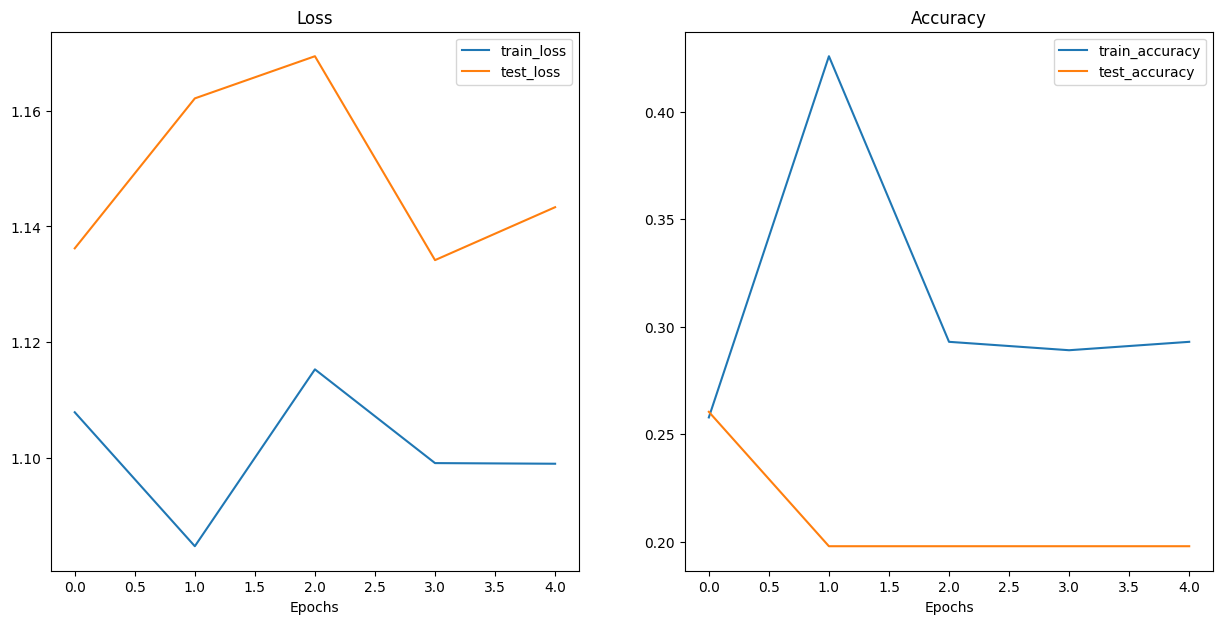

In [76]:
plot_loss_curves(model_0_results)


# What should an ideal loss curve look like?

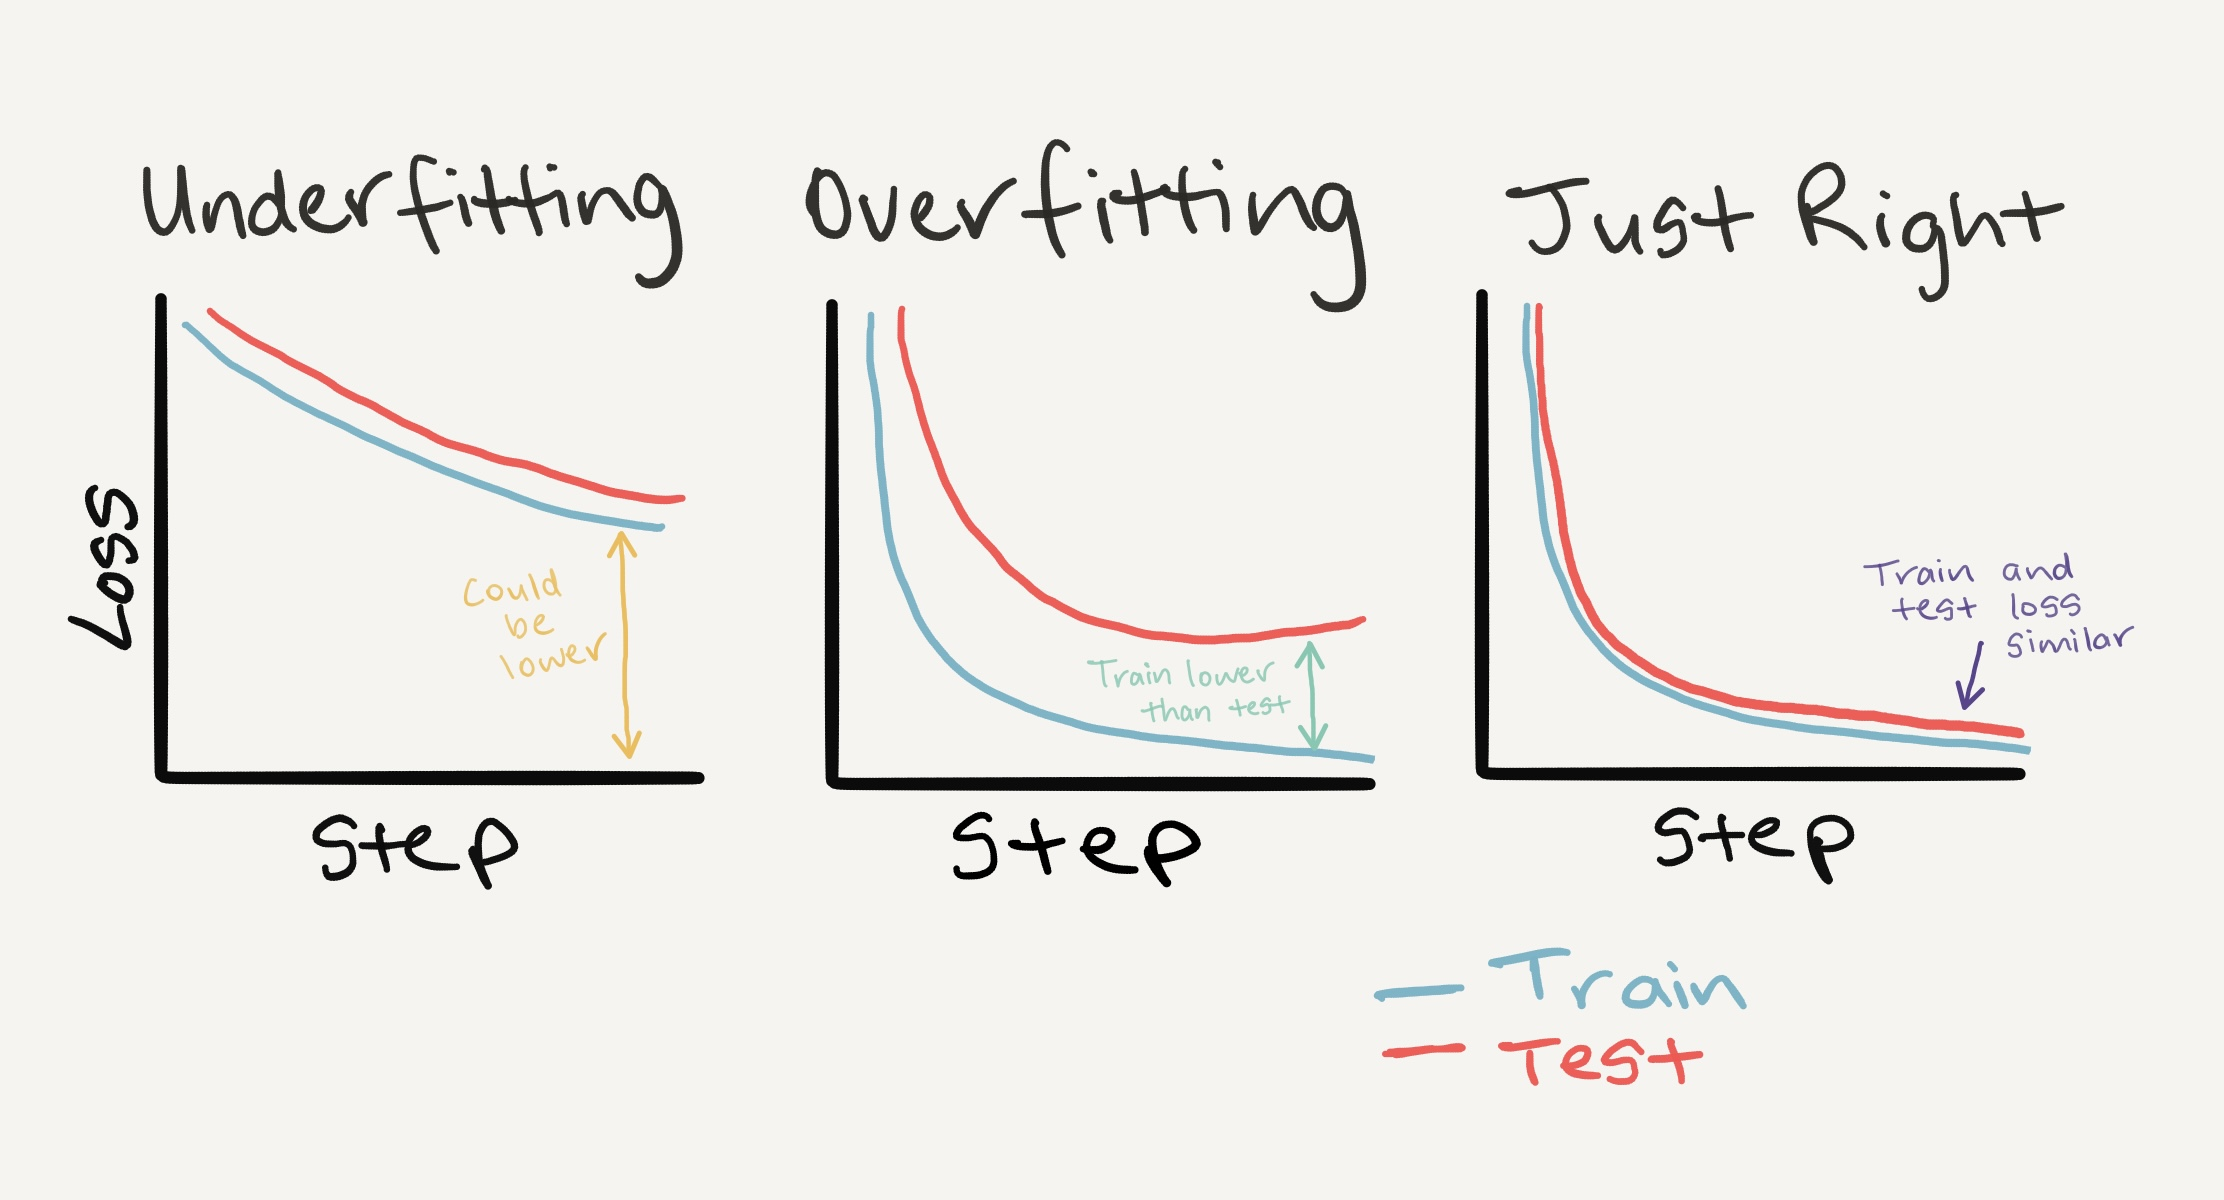

## How to deal with overfitting

Method to prevent overfitting

What is it?


Get more data

-> Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable to new examples.
Simplify your model	If the current model is already overfitting the training data, it may be too complicated of a model. This means it's learning the patterns of the data too well and isn't able to generalize well to unseen data. One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in each layer.


Use data augmentation

-> Data augmentation manipulates the training data in a way so that's harder for the model to learn as it artificially adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to generalize better to unseen data.


Use transfer learning

-> Transfer learning involves leveraging the patterns (also called pretrained weights) one model has learned to use as the foundation for your own task. In our case, we could use one computer vision model pretrained on a large variety of images and then tweak it slightly to be more specialized for food images.


Use dropout layers

-> Dropout layers randomly remove connections between hidden layers in neural networks, effectively simplifying a model but also making the remaining connections better. See torch.nn.Dropout() for more.


Use learning rate decay

-> The idea here is to slowly decrease the learning rate as a model trains. This is akin to reaching for a coin at the back of a couch. The closer you get, the smaller your steps. The same with the learning rate, the closer you get to convergence, the smaller you'll want your weight updates to be.


Use early stopping

-> Early stopping stops model training before it begins to overfit. As in, say the model's loss has stopped decreasing for the past 10 epochs (this number is arbitrary), you may want to stop the model training here and go with the model weights that had the lowest loss (10 epochs prior).

## How to deal with underfitting

Method to prevent underfitting

What is it?

Add more layers/units to your model
-> If your model is underfitting, it may not have enough capability to learn the required patterns/weights/representations of the data to be predictive. One way to add more predictive power to your model is to increase the number of hidden layers/units within those layers.

Tweak the learning rate
-> Perhaps your model's learning rate is too high to begin with. And it's trying to update its weights each epoch too much, in turn not learning anything. In this case, you might lower the learning rate and see what happens.

Use transfer learning
-> Transfer learning is capable of preventing overfitting and underfitting. It involves using the patterns from a previously working model and adjusting them to your own problem.

Train for longer
-> Sometimes a model just needs more time to learn representations of data. If you find in your smaller experiments your model isn't learning anything, perhaps leaving it train for a more epochs may result in better performance.

Use less regularization
-> Perhaps your model is underfitting because you're trying to prevent overfitting too much. Holding back on regularization techniques can help your model fit the data better.

## Model 1: TinyVGG with Data Augmentation

## Create transform with data augmentation

In [77]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

## Create train and test Dataset's and DataLoader's

In [78]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transforms)


In [79]:
train_data_augmented, test_data_simple


(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [80]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)
train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ddad46df220>,
 <torch.utils.data.dataloader.DataLoader at 0x7ddad4ac2980>)

## Construct and train Model 1

In [81]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

* Train for 5 epochs.
* Use train_dataloader=train_dataloader_augmented as the training data in train().
* Use torch.nn.CrossEntropyLoss() as the loss function (since we're working with multi-class classification).
* Use torch.optim.Adam() with lr=0.001 as the learning rate as the optimizer.

In [82]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)


In [83]:
# Set number of epochs
NUM_EPOCHS = 5

In [84]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)


In [86]:
print(model_1)


TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)


In [85]:
# Start the timer
from timeit import default_timer as timer
start_timee = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()

print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x31360 and 2560x3)

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [ ]:
# 1. Get data


In [ ]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
# Setup train and testing paths


In [ ]:
# Visualize an image

In [ ]:
# Do the image visualization with matplotlib


We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [ ]:
# 3.1 Transforming data with torchvision.transforms


In [ ]:
# Write transform for turning images into tensors


In [ ]:
# Write a function to plot transformed images


### Load image data using `ImageFolder`

In [ ]:
# Use ImageFolder to create dataset(s)


In [ ]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [ ]:
# Turn train and test Datasets into DataLoaders


(<torch.utils.data.dataloader.DataLoader at 0x7fce57ec08d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fce57ec0dd0>)

In [ ]:
# How many batches of images are in our data loaders?


(225, 75)

## 3. Recreate `model_0` we built in section 7 of notebook 04.

## 4. Create training and testing functions for `model_0`.

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches

    # Send data to target device

    # 1. Forward pass

    # 2. Calculate and accumulate loss


    # 3. Optimizer zero grad


    # 4. Loss backward


    # 5. Optimizer step


    # Calculate and accumualte accuracy metric across all batches


  # Adjust metrics to get average loss and average accuracy per batch


In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager

    # Loop through DataLoader batches

      # Send data to target device


      # 1. Forward pass


      # 2. Calculuate and accumulate loss


      # Calculate and accumulate accuracy


  # Adjust metrics to get average loss and accuracy per batch


In [ ]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.

In [ ]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(#TODO,
                             lr=0.001)

In [ ]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(#TODO,
                             lr=0.001)

In [ ]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(#TODO,
                             lr=0.001)

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [ ]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)


It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [ ]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

In [ ]:
# See how many images we have
walk_through_dir(image_path)

Excellent, we now have double the training and testing images...

In [ ]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

In [ ]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

# Create datasets


# Create dataloaders


In [ ]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction.
* Does the model you trained in exercise 7 get it right?
* If not, what do you think you could do to improve it?